In [1]:
from seirsplus.models import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import json
import  pickle
from shapely.geometry import Polygon, Point, MultiPoint
from scipy.spatial import ConvexHull
from dateutil import parser

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (16,40)

In [3]:
def get_three_tuple(df):
    arr = []
    for row in df.iterrows():
        v1 = np.percentile(row[1], 25)
        v2 = np.percentile(row[1], 50)
        v3 = np.percentile(row[1], 75)
        v4 = np.percentile(row[1], 2.5)
        v5 = np.percentile(row[1], 97.5)
        arr.append(np.array([v1,v2,v3, v4, v5]))
    return np.array(arr)

def gen_ts(patch, dates, keys):
    hull = [patch[j] for j in ConvexHull(patch).vertices]
    poly = Polygon(hull)
    pop = 0
    ts = []
    count = 0
    for k in keys:
        if k not in dates:
            ts.append((k, count))
            continue
        for case in dates[k]:
            point = Point(*case)
            if poly.buffer(0.0001).contains(point):
                count+=1
        ts.append((k, count))

    return ts

In [4]:
df = pd.read_csv("data/data3.csv")

In [5]:
for i,j in df.iterrows():
    try:
        d = parser.parse(j['Admission Date'])
    except:
        df['Admission Date'][i] = j['Registration Date']

/home/students/Networks/networks/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [6]:
dates = {}
for _,row in df.iterrows():
    try:
        dt = parser.parse(row['Admission Date'])
        key = (dt.year,dt.month,dt.day)
        try:
            dates[key].append((row['Latitude'],row['Longitude']))
        except:
            dates[key] = [(row['Latitude'],row['Longitude']),]
    except:
        pass

In [7]:
with open('region_sim1.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S5_ts = gen_ts(S5['patch'], dates, keys)
S10_ts = gen_ts(S10['patch'], dates, keys)
S20_ts = gen_ts(S20['patch'], dates, keys)

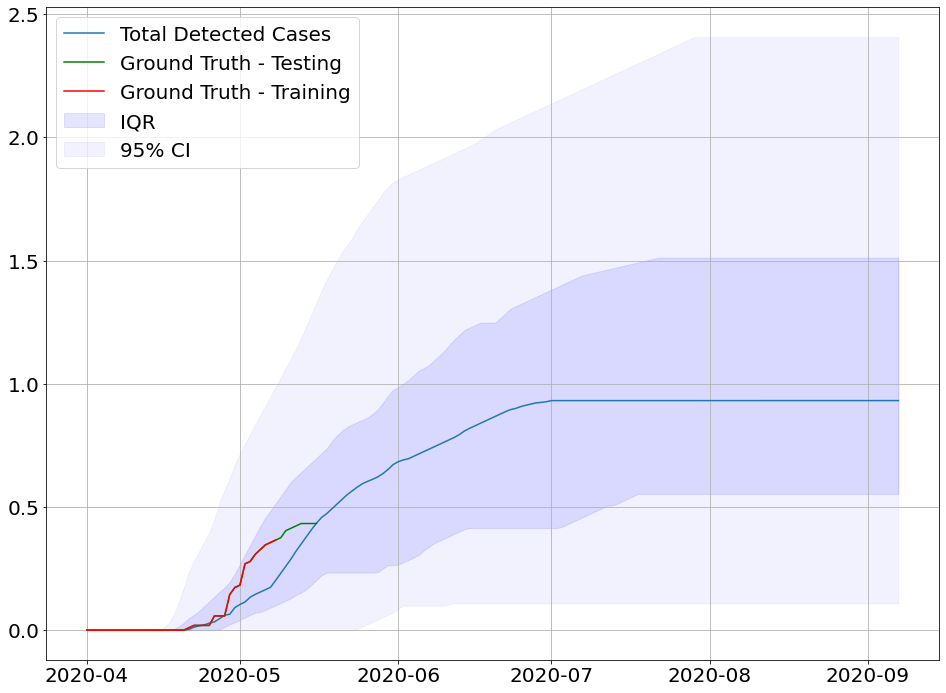

In [29]:
with open('data/region1_S10.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Ground Truth - Testing'
)

plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(loc='upper left', fontsize =20)
plt.savefig('figures/'+'f2-2.svg')

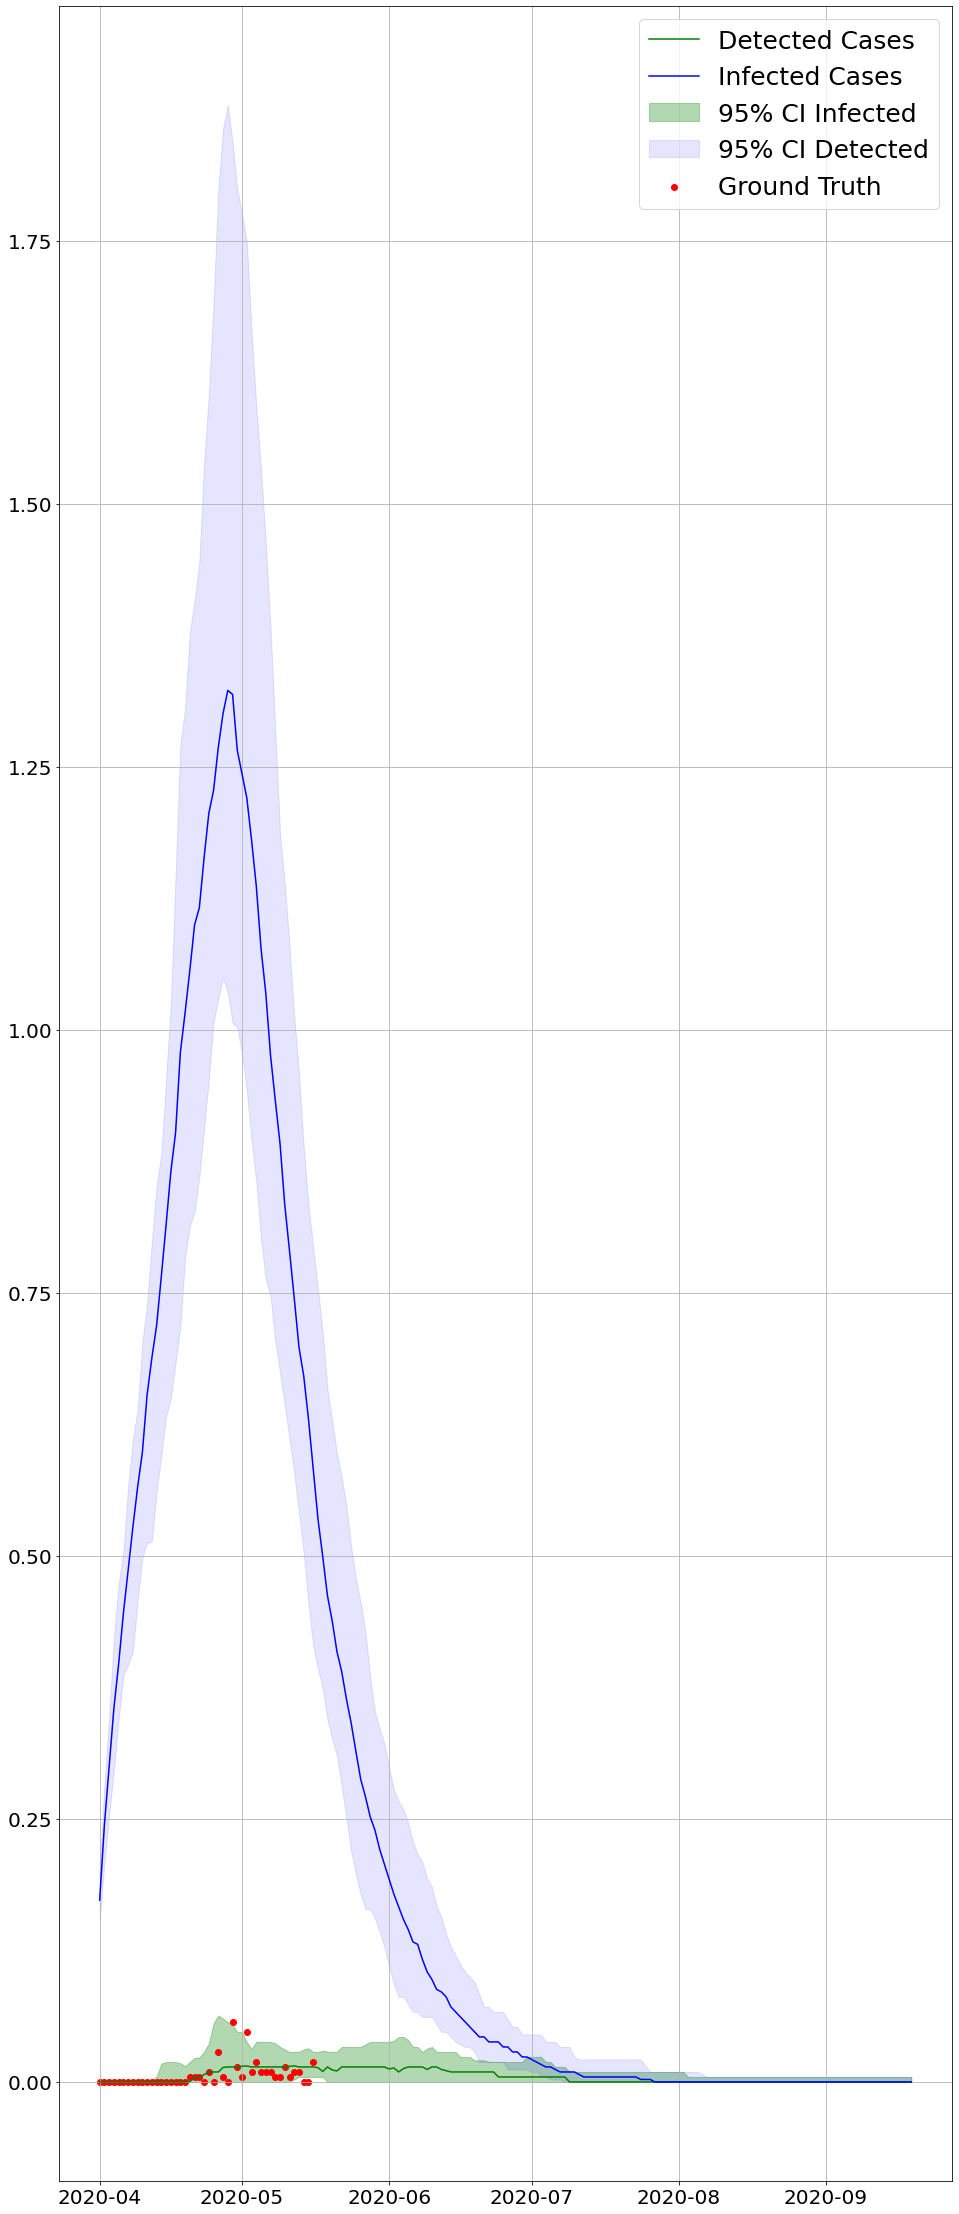

In [8]:
with open('data/region1_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.plot(dfa_DI.index, cumu[:,1],'g', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='g', alpha=.3, label='95% CI Infected'
    )


dfa_DI = temp[0]
cumu = get_three_tuple(dfa_DI)

plt.plot(dfa_DI.index, cumu[:,1],'b', label='Infected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.1, label='95% CI Detected'
    )

plt.scatter(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]])-np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[14:-1]]),
    c='r', label='Ground Truth'
)

plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(loc='upper right', fontsize =25)
plt.savefig('figures/'+'f2-4.svg')

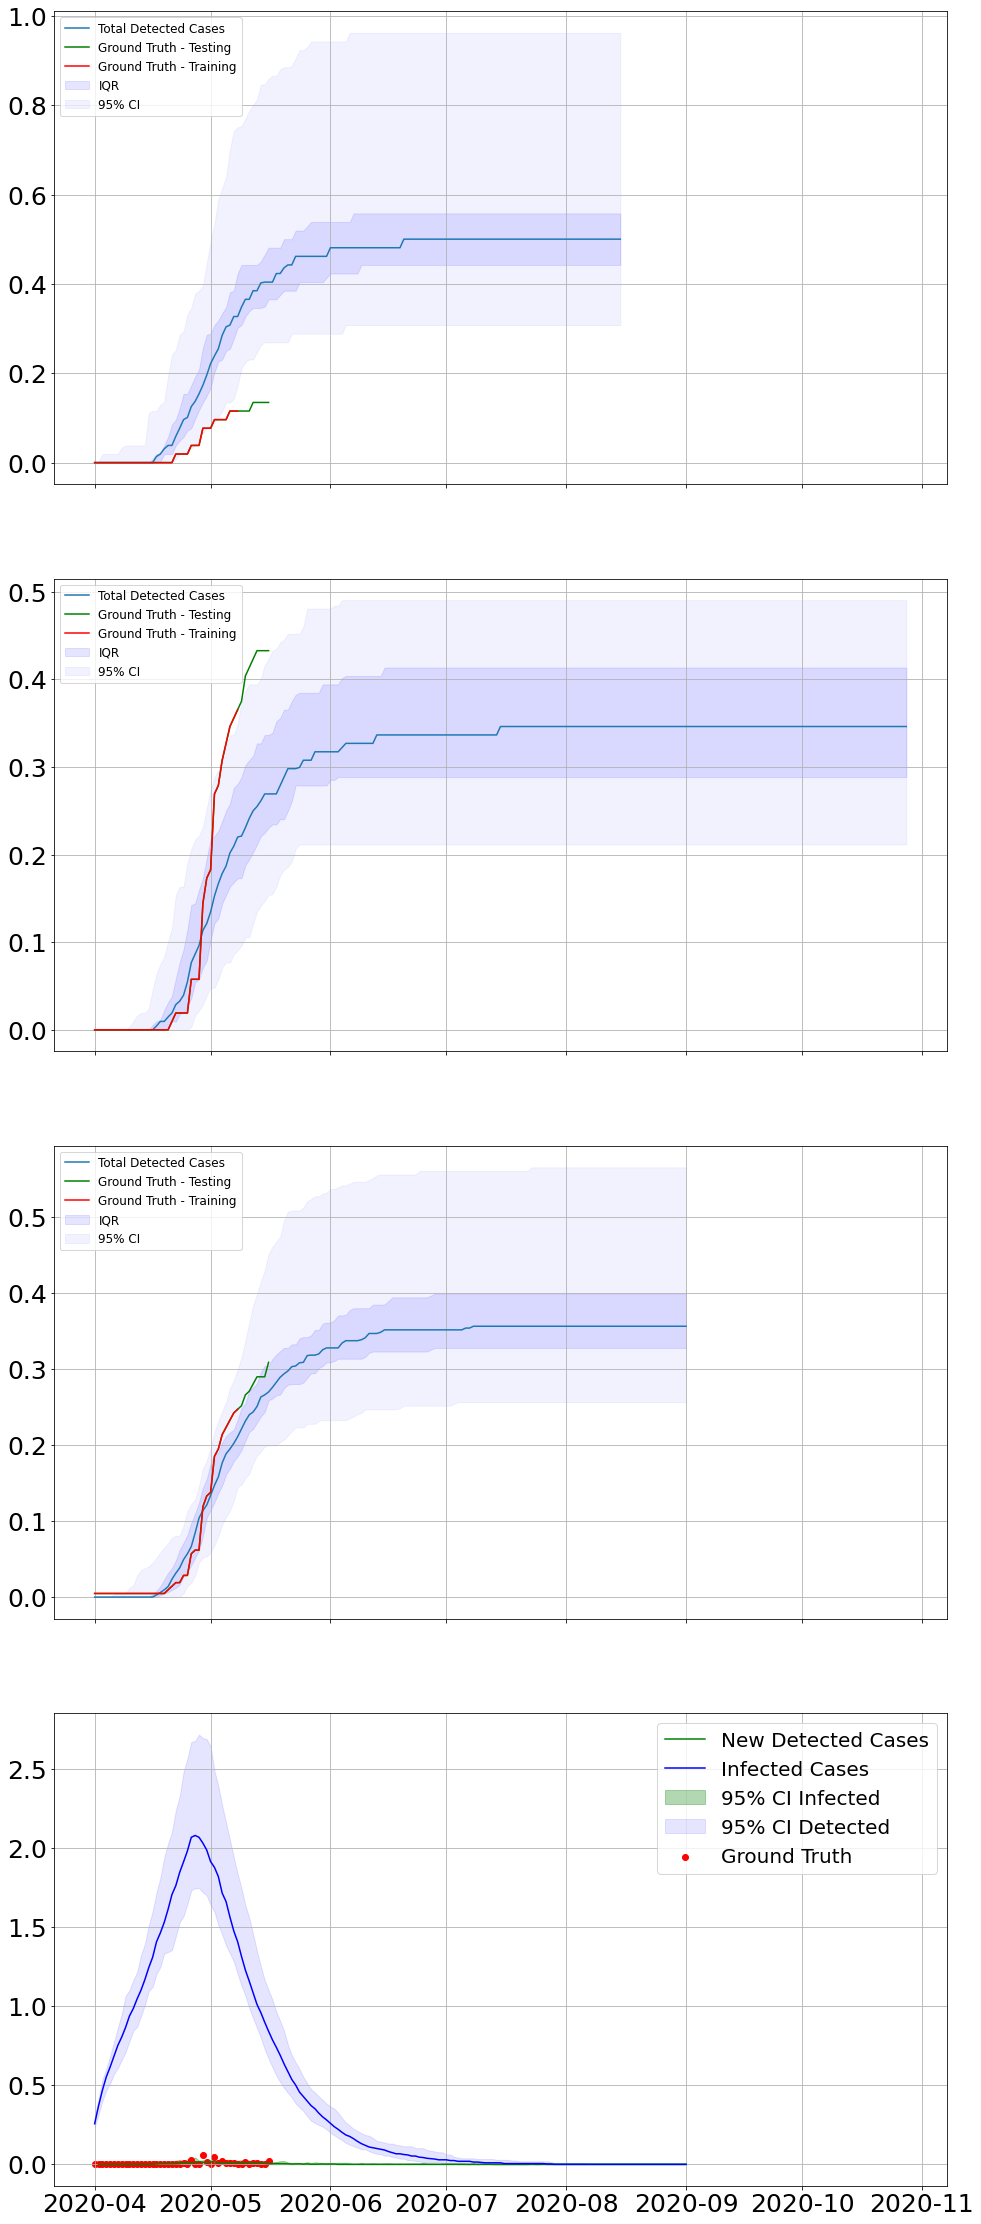

<Figure size 288x216 with 0 Axes>

In [8]:
# fig 2

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

figlegend = plt.figure(figsize=(4,3))

with open('data/region1_S5c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax1.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax1.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax1.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax1.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax1.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax1.grid()
ax1.xaxis.set_tick_params(labelsize=25)
ax1.yaxis.set_tick_params(labelsize=25)
ax1.legend(loc='upper left', fontsize =12)


with open('data/region1_S10c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax2.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax2.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax2.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax2.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax2.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax2.grid()
ax2.xaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)
ax2.legend(loc='upper left', fontsize =12)


with open('data/region1_S20c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax3.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax3.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax3.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax3.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax3.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax3.grid()
ax3.xaxis.set_tick_params(labelsize=25)
ax3.yaxis.set_tick_params(labelsize=25)
ax3.legend(loc='upper left', fontsize =12)


with open('data/region1_S20c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.diff(axis=0))

ax4.plot(dfa_DI.index, cumu[:,1],'g', label='New Detected Cases')
ax4.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='g', alpha=.3, label='95% CI Infected'
    )


dfa_DI = temp[0]
cumu = get_three_tuple(dfa_DI)

ax4.plot(dfa_DI.index, cumu[:,1],'b', label='Infected Cases')
ax4.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.1, label='95% CI Detected'
    )

ax4.scatter(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]])-np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[14:-1]]),
    c='r', label='Ground Truth'
)

ax4.grid()
ax4.xaxis.set_tick_params(labelsize=25)
ax4.yaxis.set_tick_params(labelsize=25)

ax4.legend(loc='upper right', fontsize =20)

fig.savefig('figures/'+'f2.svg')

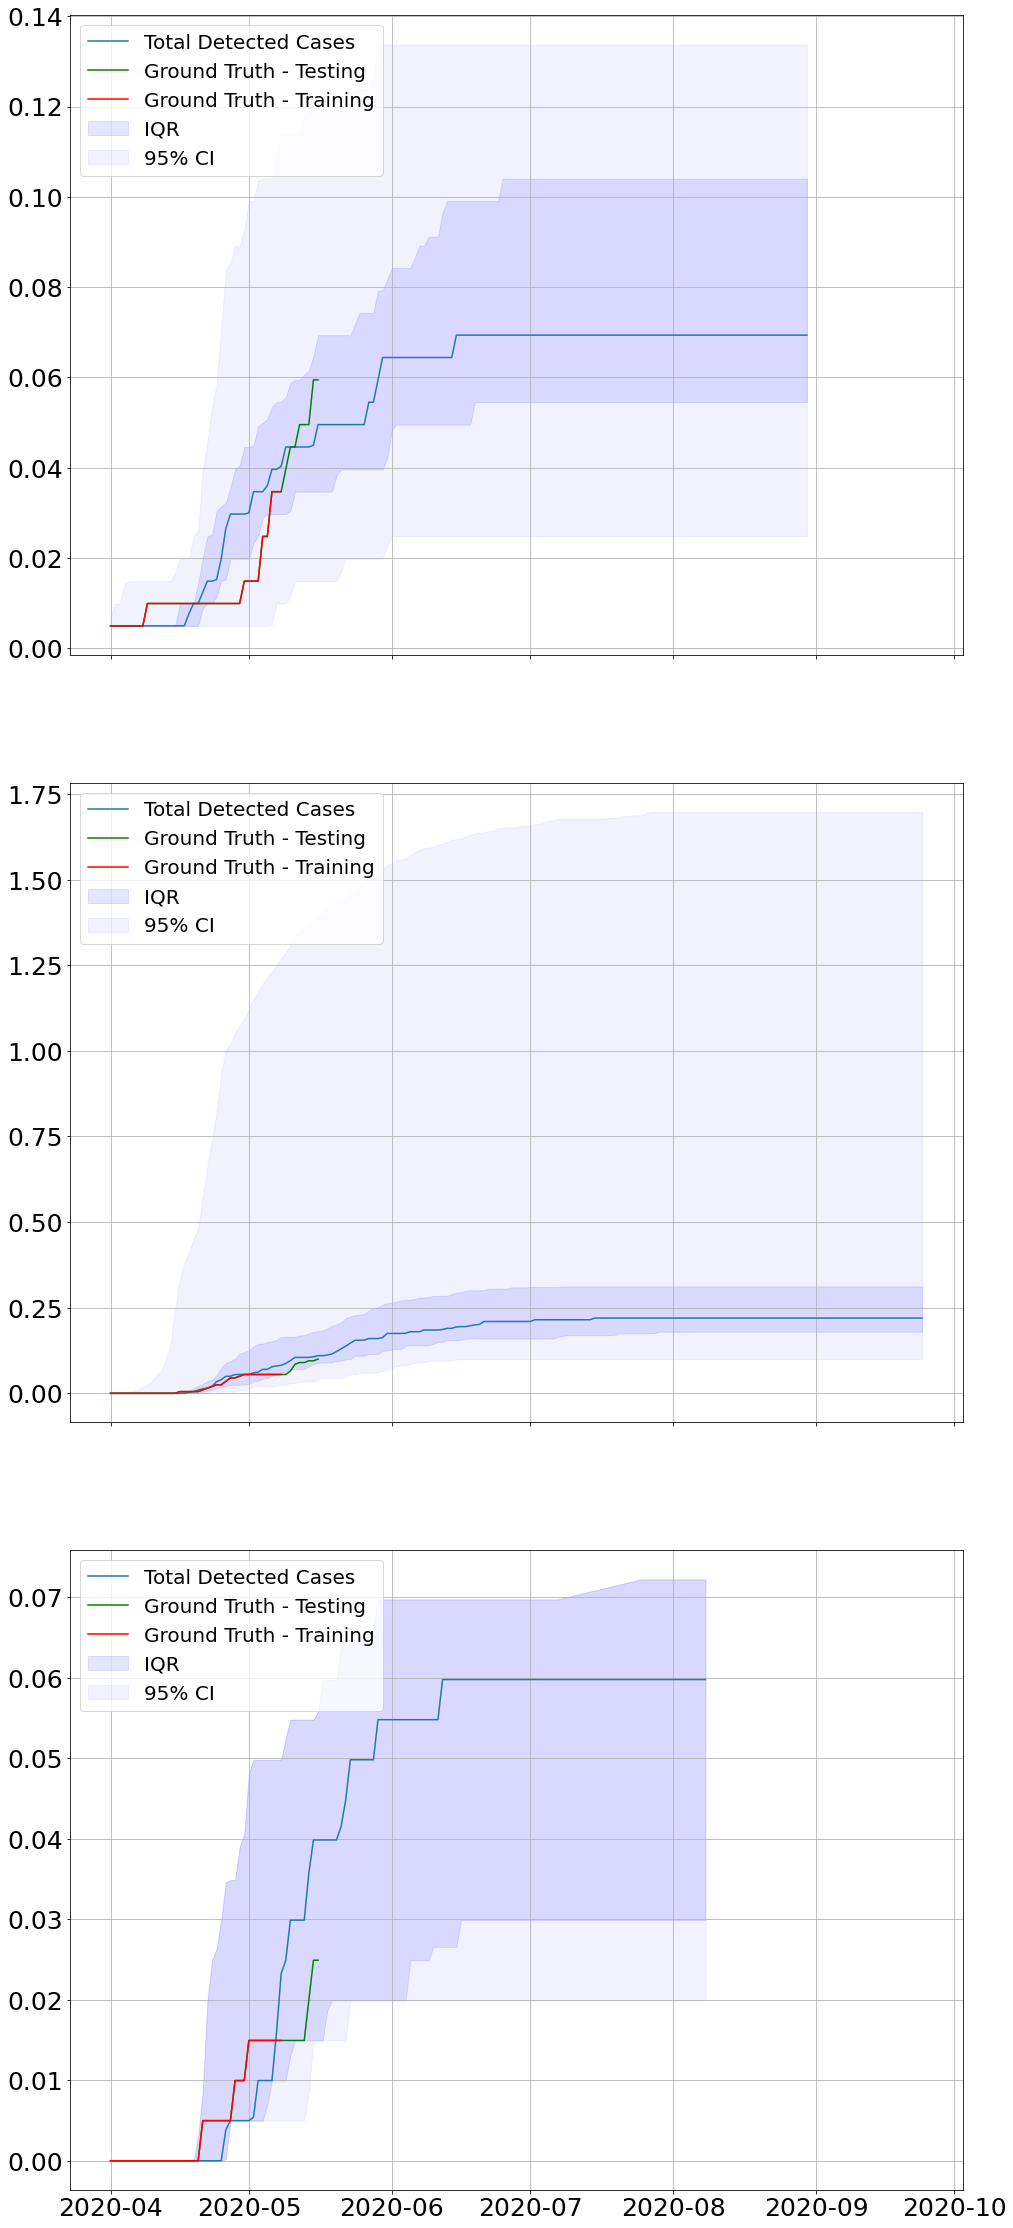

In [12]:
# fig 3

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

with open('region_sim2.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S20_ts = gen_ts(S20['patch'], dates, keys)

with open('data/region2_S20c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax1.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax1.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax1.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax1.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax1.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1]-1)*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax1.grid()
ax1.xaxis.set_tick_params(labelsize=25)
ax1.yaxis.set_tick_params(labelsize=25)
ax1.legend(loc='upper left', fontsize =20)

with open('region_sim3.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S20_ts = gen_ts(S20['patch'], dates, keys)


with open('data/region3_S20c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax2.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax2.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax2.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax2.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax2.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax2.grid()
ax2.xaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)
ax2.legend(loc='upper left', fontsize =20)


with open('region_sim4.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S20_ts = gen_ts(S20['patch'], dates, keys)


with open('data/region4_S20c.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 5000 Population Cumulative Cases'

#plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

ax3.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
ax3.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax3.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )

ax3.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Ground Truth - Testing'
)

ax3.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Ground Truth - Training'
)

ax3.grid()
ax3.xaxis.set_tick_params(labelsize=25)
ax3.yaxis.set_tick_params(labelsize=25)
ax3.legend(loc='upper left', fontsize =20)

fig.savefig('figures/'+'f3.svg')

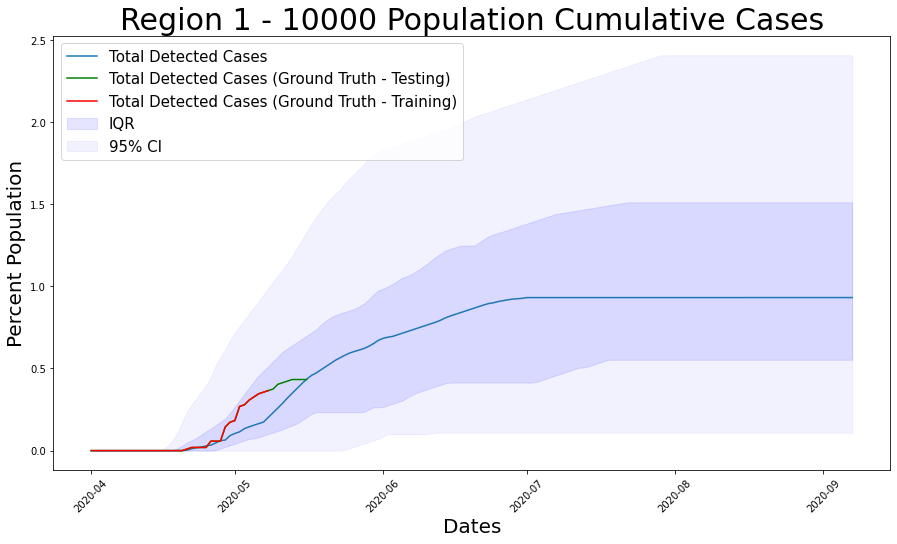

In [9]:
with open('data/region1_S10.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 10000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

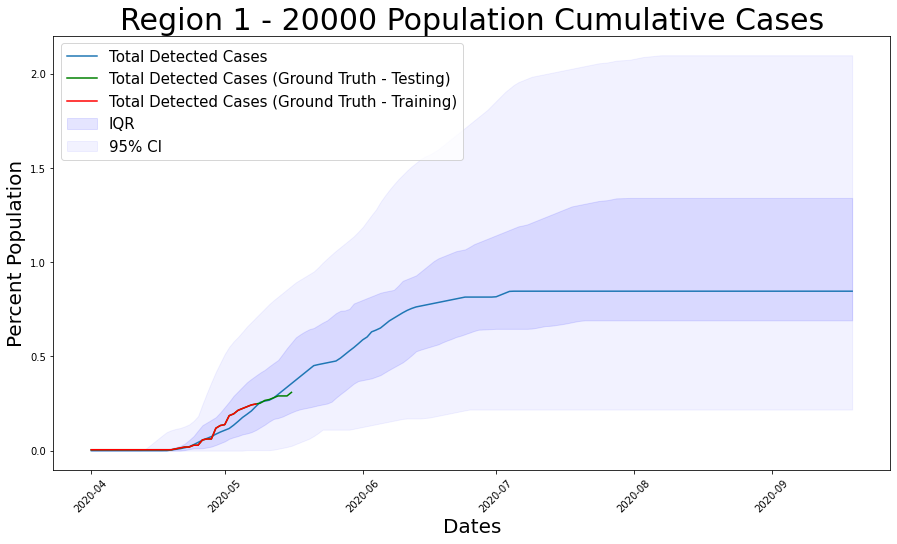

In [10]:
with open('data/region1_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 20000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

In [ ]:
with open('data/region1_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 1 - 20000 Population Predictions'

plt.title(title, fontsize =30)

dfa_I = temp[0]
cumu = get_three_tuple(dfa_I)

plt.plot(dfa_I.index, cumu[:,1],'b', label='Infected Cases')

plt.fill_between(
    dfa_I.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI Infected'
    )

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)

plt.plot(dfa_DI.index, cumu[:,1], 'g', label='Detected Cases')

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='g', alpha=.3, label='95% CI Detected'
    )

plt.scatter(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]])-np.array([float(j[1])*100/S20['total_pop'] for j in S20_ts[14:-1]]),
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend(loc='upper right', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

In [11]:
with open('region_sim2.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S5_ts = gen_ts(S5['patch'], dates, keys)
S10_ts = gen_ts(S10['patch'], dates, keys)
S20_ts = gen_ts(S20['patch'], dates, keys)

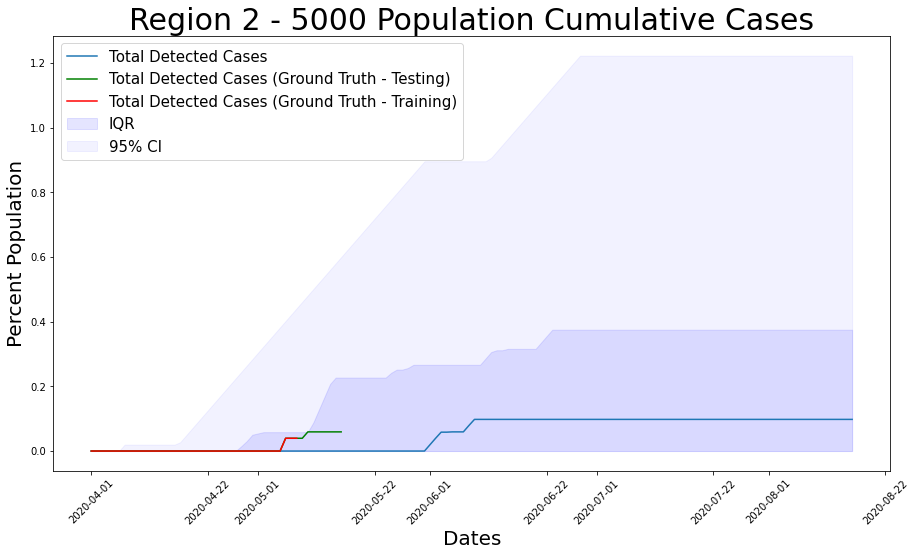

In [12]:
with open('data/region2_S5.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 2 - 5000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )



plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)

plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

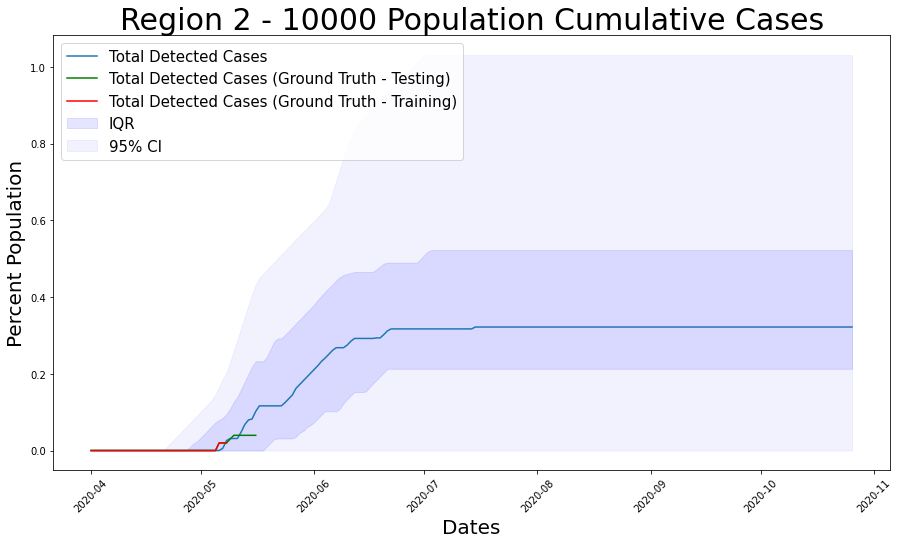

In [13]:
with open('data/region2_S10.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 2 - 10000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

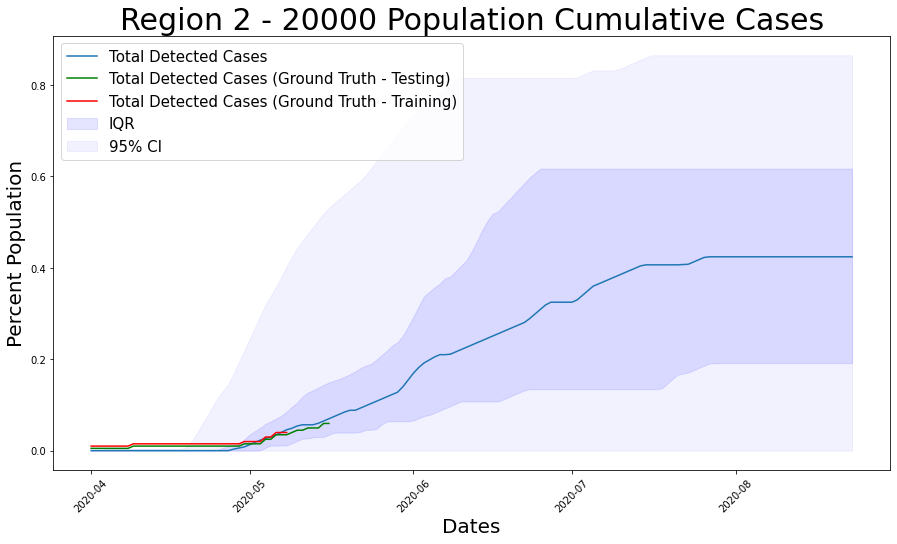

In [14]:
with open('data/region2_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 2 - 20000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

In [15]:
with open('region_sim3.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S5_ts = gen_ts(S5['patch'], dates, keys)
S10_ts = gen_ts(S10['patch'], dates, keys)
S20_ts = gen_ts(S20['patch'], dates, keys)

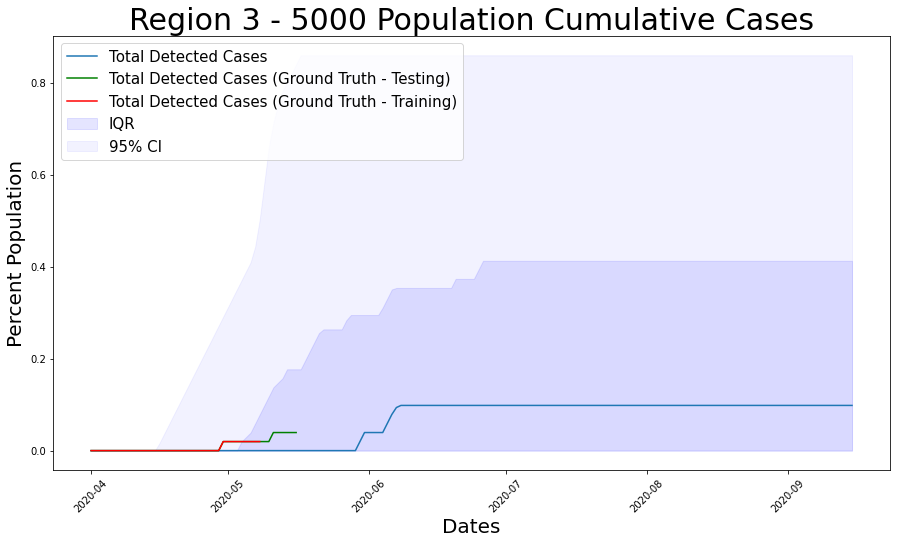

In [16]:
with open('data/region3_S5.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 3 - 5000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )



plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)

plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

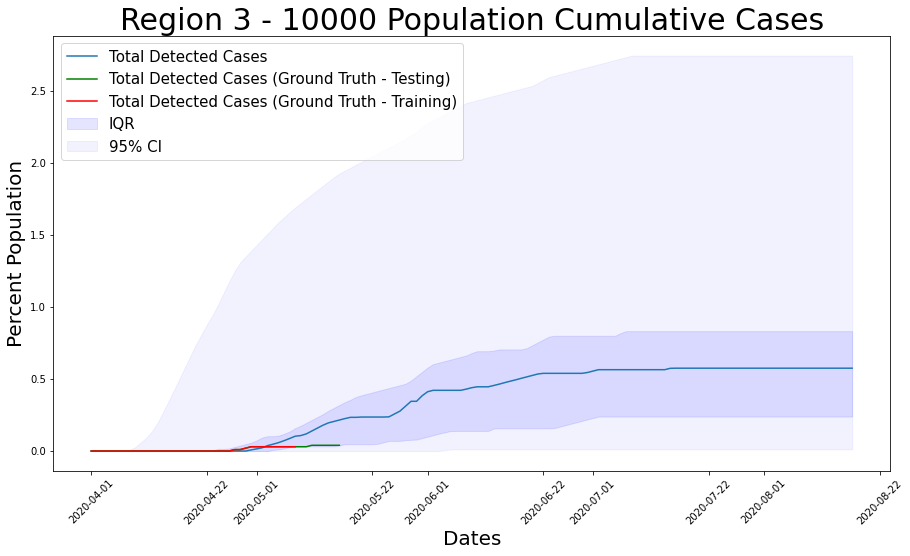

In [17]:
with open('data/region3_S10.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 3 - 10000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

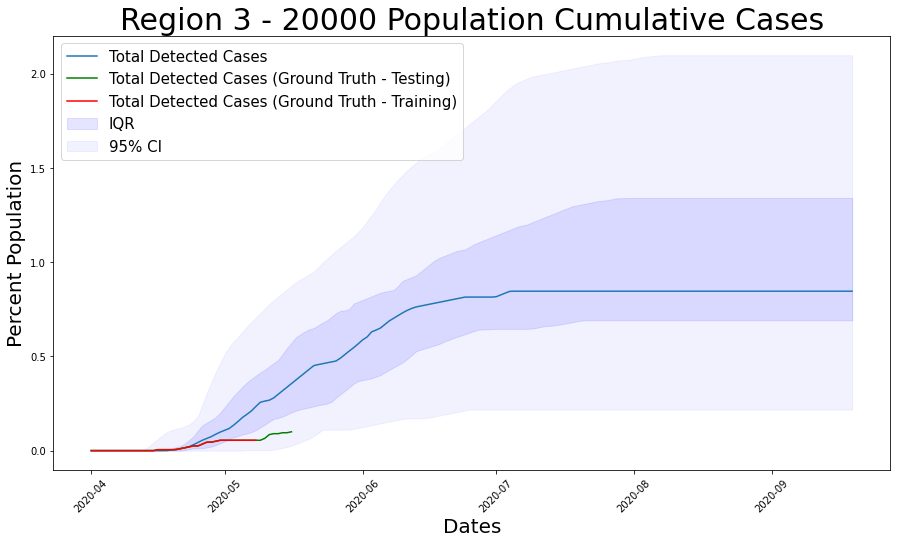

In [18]:
with open('data/region1_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 3 - 20000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

In [19]:
with open('region_sim4.p','rb') as fp:
    S5, S10, S20 = pickle.load(fp)

keys = sorted(set([j[0] for j in S5['timeseries']]).union(set(dates.keys())))
S5_ts = gen_ts(S5['patch'], dates, keys)
S10_ts = gen_ts(S10['patch'], dates, keys)
S20_ts = gen_ts(S20['patch'], dates, keys)

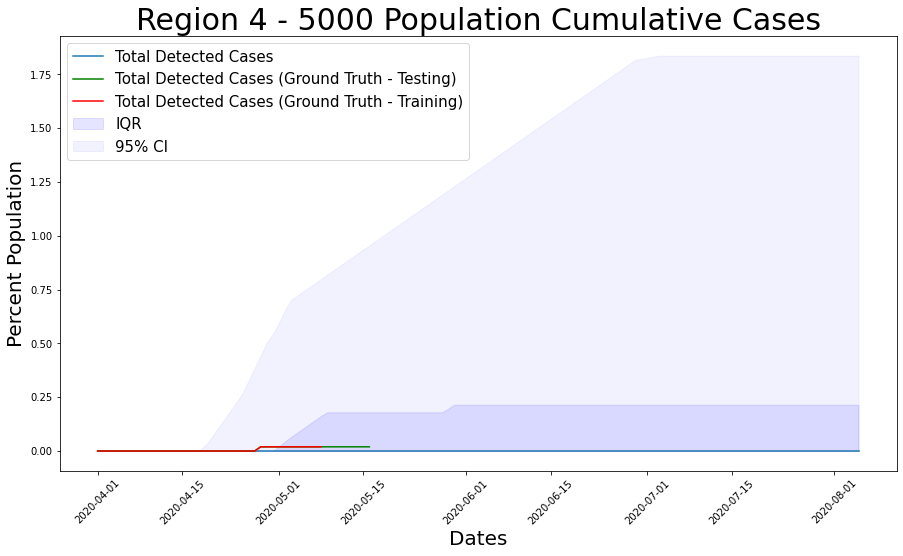

In [20]:
with open('data/region4_S5.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 4 - 5000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )


plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)

plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S5['total_pop'] for j in S5['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

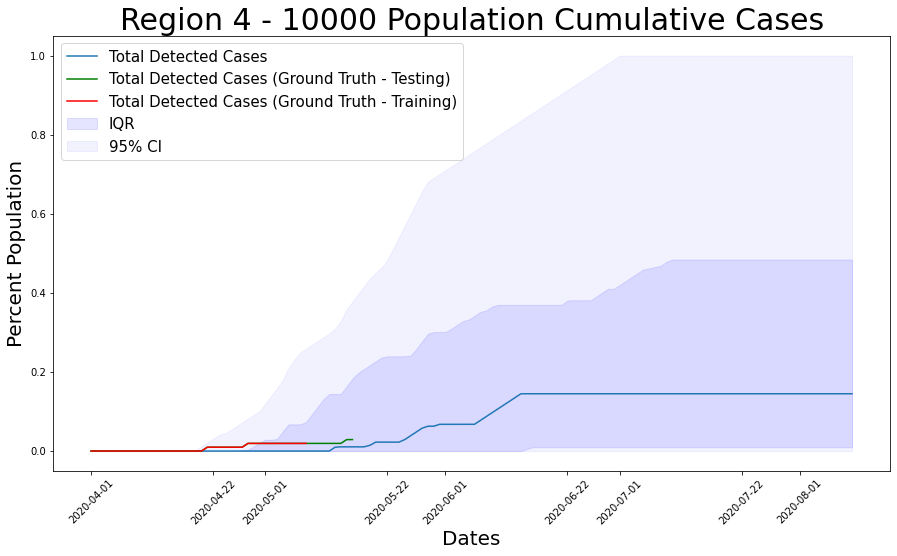

In [21]:
with open('data/region4_S10.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 4 - 10000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S10['total_pop'] for j in S10['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')

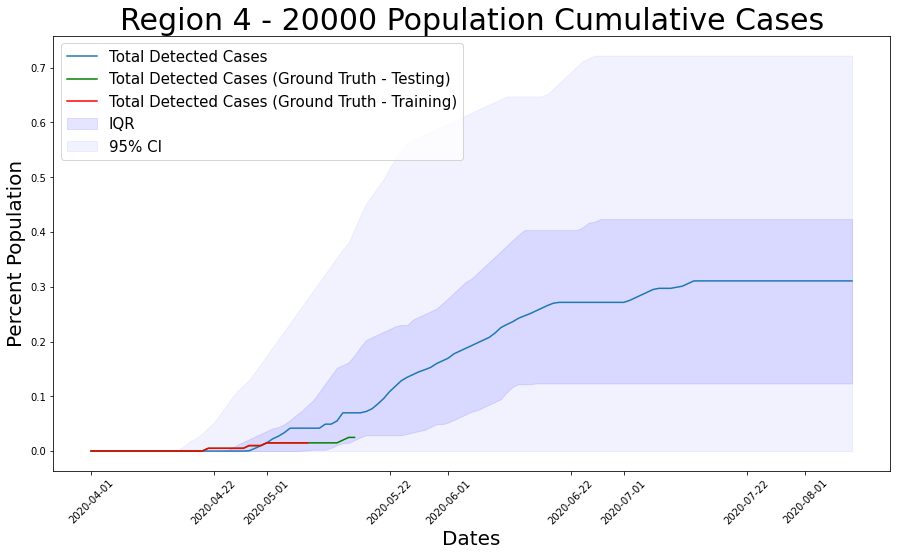

In [22]:
with open('data/region4_S20.p', 'rb') as fp:
    temp = pickle.load(fp)

title = 'Region 4 - 20000 Population Cumulative Cases'

plt.title(title, fontsize =30)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI.cumsum(axis=0))

plt.xlabel('Dates', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Percent Population' , fontsize =20)
plt.plot(dfa_DI.index, cumu[:,1], label='Total Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='IQR'
    )

plt.fill_between(
    dfa_DI.index,
    cumu[:,3],
    cumu[:,4],
     color='b', alpha=.05, label='95% CI'
    )


plt.plot(
    list(dfa_DI.index)[:len(S10_ts[15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20_ts[15:]],
    'g', label='Total Detected Cases (Ground Truth - Testing)'
)
plt.plot(
    list(dfa_DI.index)[:len(S10['timeseries'][15:])],
    [float(j[1])*100/S20['total_pop'] for j in S20['timeseries'][15:]],
    'r', label='Total Detected Cases (Ground Truth - Training)'
)

plt.legend(loc='upper left', fontsize =15)
plt.savefig('testing_sim/'+title+'.svg')